In [ ]:
%pip install -r requirements.txt

#### Imports

In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import librosa
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import wavfile

from qbstyles import mpl_style

mpl_style(dark=True)

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


#### Load & Preprocess data

In [7]:
# Define paths
GUNSHOT_PATH = "../data/gunshots/"
NON_GUNSHOT_PATH = "../data/non_gunshots/"

# Function to load and preprocess audio files
def load_and_preprocess_data(folder_path, label, sample_rate=44100, duration=1):
    data = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith(".wav"):
            file_path = os.path.join(folder_path, file)
            audio, _ = librosa.load(file_path, sr=sample_rate, duration=duration)
            if len(audio) < sample_rate * duration:
                audio = np.pad(audio, (0, sample_rate * duration - len(audio)), mode='constant')
            data.append(audio)
            labels.append(label)
    return np.array(data), np.array(labels)

# Load gunshot and non-gunshot data
gunshot_data, gunshot_labels = load_and_preprocess_data(GUNSHOT_PATH, label=1)
non_gunshot_data, non_gunshot_labels = load_and_preprocess_data(NON_GUNSHOT_PATH, label=0)

# Combine data
X = np.concatenate((gunshot_data, non_gunshot_data))
y = np.concatenate((gunshot_labels, non_gunshot_labels))

# Reshape X for CNN input
X = X.reshape(X.shape[0], X.shape[1], 1)

#### Train VS. Test Split (80:20 ratio)

In [11]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Model Arch (CNN)

In [42]:
model = models.Sequential([
    Input(shape=(44100, 1)),  # Add Input layer
    layers.Conv1D(32, kernel_size=5, activation='relu'),
    layers.MaxPooling1D(pool_size=4),
    layers.Conv1D(64, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(128, kernel_size=3, activation='relu'),
    layers.MaxPooling1D(pool_size=2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_12 (Conv1D)              │ (None, 44096, 32)      │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 11024, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 11022, 64)      │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 5511, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 5509, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 2754, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 352512)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │    45,121,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,152,897 (172.24 MB)

 Trainable params: 45,152,897 (172.24 MB)

 Non-trainable params: 0 (0.00 B)

##### Training the Model

In [43]:
# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 36s 800ms/step - accuracy: 0.6348 - loss: 0.8618 - val_accuracy: 0.7265 - val_loss: 0.6055
Epoch 2/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 788ms/step - accuracy: 0.7255 - loss: 0.5708 - val_accuracy: 0.8147 - val_loss: 0.4443
Epoch 3/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 786ms/step - accuracy: 0.8501 - loss: 0.3466 - val_accuracy: 0.8324 - val_loss: 0.4003
Epoch 4/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 806ms/step - accuracy: 0.9441 - loss: 0.1534 - val_accuracy: 0.8500 - val_loss: 0.4469
Epoch 5/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 788ms/step - accuracy: 0.9731 - loss: 0.1070 - val_accuracy: 0.8059 - val_loss: 0.7271
Epoch 6/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 792ms/step - accuracy: 0.9894 - loss: 0.0570 - val_accuracy: 0.8324 - val_loss: 0.6429
Epoch 7/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 42s 811ms/step - accuracy: 0.9879 - loss: 0.0519 - val_accuracy: 0.8559 - val_loss: 0.6816
Epoch 8/10
43/43 ━━━━━━━━━━━━━━━━━━━━ 34s 796ms/step - accuracy: 0.9890 - loss: 0.0519 - val_accu

##### Confusion Matrix & Other Metrics

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 187ms/step


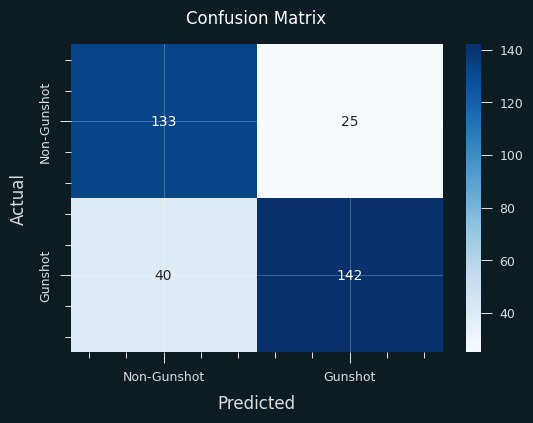

              precision    recall  f1-score   support

 Non-Gunshot       0.77      0.84      0.80       158
     Gunshot       0.85      0.78      0.81       182

    accuracy                           0.81       340
   macro avg       0.81      0.81      0.81       340
weighted avg       0.81      0.81      0.81       340



In [44]:
# Predict on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Gunshot', 'Gunshot'], yticklabels=['Non-Gunshot', 'Gunshot'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_classes, target_names=['Non-Gunshot', 'Gunshot']))

##### Model's evaluations

11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 180ms/step - accuracy: 0.8008 - loss: 0.9549
Test Accuracy: 80.88%


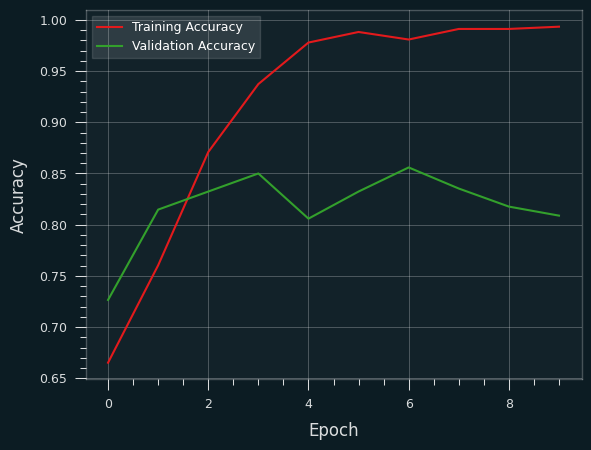

In [45]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Saving the trained Model

In [ ]:
# Save the trained model
model.save("../models/gunshot_classification_model.keras")